In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import regularAtlmask

In [2]:
datafolder = ''

In [3]:
experiment = 'E280'
model = 'EC-Earth3-LR'
folder = datafolder+'Raw_data/'+model+'/'

In [4]:
dsV = xr.open_dataset(folder+experiment+'/vo_100yr.nc')
dsT = xr.open_dataset(folder+experiment+'/thetao_100yr.nc')
dsS = xr.open_dataset(folder+experiment+'/so_100yr.nc')
dsice = xr.open_dataset(folder+experiment+'/si_monthly.nc')

dsOHT = xr.open_dataset(folder+experiment+'/hfbasin_100yr.nc')
dsAMOC = xr.open_dataset(folder+experiment+'/amoc_100yr.nc')

if experiment == 'E280':
    #dsr = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/EC-Earth3-LR/'+experiment+'/basin_Ofx_EC-Earth3-LR_piControl_r1i1p1f1_gn.nc') #File is corrupted: no regions
    dsr = xr.open_dataset(folder+'Eoi400/basin_Ofx_EC-Earth3-LR_midPliocene-eoi400_r1i1p1f1_gn.nc') #Region file with PI geography, probably same for all experiments
else:
    dsr = xr.open_dataset(folder+experiment+'/basin_Ofx_EC-Earth3-LR_midPliocene-eoi400_r1i1p1f1_gn.nc')

## Separation MOC and gyre OHT component 100-yr average

In [5]:
dsV = dsV.rename({'longitude': 'ULONG', 'latitude': 'ULAT'})
dsT = dsT.rename({'longitude': 'TLONG', 'latitude': 'TLAT'})
dsr = dsr.rename({'longitude': 'TLONG', 'latitude': 'TLAT'})

In [6]:
temp = dsT.thetao
region = dsr.basin

#Regrid velocity field to the temperature field, using 0 as a fill value for land to avoid NaN ocean grid cells after interpolation
regridder = xe.Regridder(dsV, dsT, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.vo.fillna(0)*100
vvel = regridder(vo) #cm/s
vvel = vvel*temp/temp #Mask land with NaN values of the T grid

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


Create DXT grid

In [7]:
dphi = np.zeros([292,362])
lat = dsT.TLAT.values
dphi[:,1:] = lat[:,1:]-lat[:,:-1]
dphi[:,0] = lat[:,0]-lat[:,-1]
dphi = np.radians(dphi)

dtheta = np.zeros([292,362])
lon = dsT.TLONG.values
dtheta[:,1:] = lon[:,1:]-lon[:,:-1]
dtheta[:,0] = lon[:,0]-lon[:,-1]

for j in range(292):
    for i in range(240,300):
        if dtheta[j,i] < -300:
            dtheta[j,i] = dtheta[j,i]+360
dtheta = np.radians(dtheta)

phi1 = np.zeros([292,362])
phi1[:,0] = lat[:,-1]
phi1[:,1:] = lat[:,:-1]
phi1 = np.radians(phi1)

phi2 = np.radians(lat)

r = 6.37122e8 #radius Earth in cm
d = 2*r*np.arcsin(np.sqrt(np.sin(dphi/2)**2+np.cos(phi1)*np.cos(phi2)*np.sin(dtheta/2)**2)) #Distance between adjacent cells in i dimension on U grid [cm]
dsT['d'] = xr.DataArray(data=d, dims=("j","i")) 
DXT = np.zeros([292,362])
DXT[:,:-1] = (d[:,1:]+d[:,:-1])/2
DXT[:,-1] = (d[:,0]+d[:,-1])/2

dsT['DXT'] = xr.DataArray(data=DXT, dims=("j","i")) #Grid lengths centered on T-points [cm]

Create DZ array

In [8]:
#1-D array with spacing of depth grid
ds = dsT.copy(deep=True)

dz = np.zeros(len(ds.lev))
dz[0] = ds.lev[0].values*2
depth = dz[0]
for i in range(1,len(ds.lev)):
    dz[i] = (ds.lev[i]-depth)*2
    depth = depth+dz[i]
dz = dz*100 #Depth spacing. Units: cm
dsV['DZ'] = xr.DataArray(data=dz, dims=("lev"))
dsT['DZ'] = xr.DataArray(data=dz, dims=("lev"))
DZ = dsT.DZ

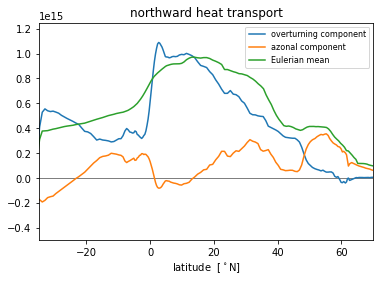

In [9]:
cp_sw = 3996.  # [J/(kg degC)]   heat capacity of water
rho_sw = 1.026e-3  # [kg/cm^3]  density of water

VVEL = vvel.where(region==2) #cm/s
HEAT = (cp_sw*rho_sw*temp).where(region==2)  #  [J/(kg K) * kg/cm^3 * degC] = [J/cm]

def zonal_means(x, dx):
    xint = (x*dx).sum('i')  # [x-unit * cm]
    zm = xint/dx.sum('i')   # [x-unit]
    return xint, zm

#Zonal mean velocity and heat
VVEL_xint, VVEL_zm = zonal_means(VVEL, dsT.DXT.where(VVEL<10000))
HEAT_xint, HEAT_zm = zonal_means(HEAT, dsT.DXT.where(VVEL<10000))

#Make zonal mean fields into 3D fields again
HEAT_zm_3D = HEAT/HEAT
HEAT_zm_3D = HEAT_zm_3D*HEAT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

#azonal components on u grid
HEAT_prime = (HEAT - HEAT_zm) # azonal heat component (x,y,z) [J/cm]
VVEL_prime = (VVEL - VVEL_zm)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to compute OHTov and OHTaz
Hov = (VVEL_zm_3D*HEAT_zm_3D*dsT.DXT*dsT.DZ).sum(dim=['i','lev'])
Haz = (VVEL_prime*HEAT_prime*dsT.DXT*dsT.DZ).sum(dim=['i','lev'])  # product of primed velocity and heat [cm/s * J/cm^2 * cm]

# Auxiliary latitudes for OHT components
lats = dsT.TLAT.where(region==2).mean(dim='i')

plt.figure(figsize=(6,4))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Hov, label='overturning component')

plt.plot(lats, Haz, label='azonal component')
#plt.plot(lats, (Hov+Haz)/1e15, label='overturning+azonal')
plt.plot(dsOHT.lat, dsOHT.hfbasin,label='Eulerian mean')
plt.title('northward heat transport')
plt.xlim([-35,70])
plt.ylim([-0.5e15, 1.25e15])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [10]:
dsE = xr.Dataset(data_vars = dict(OHTov=(["lat"], Hov[2:-2]/1e15), OHTaz=(["lat"], Haz[2:-2]/1e15)), coords = dict(lat = lats[2:-2].values))
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomOHT_100yr.nc')

## 100-yr average AMOC

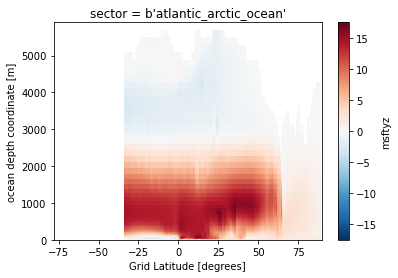

In [11]:
#Mask zero values 
a = dsAMOC.msftyz/rho_sw/1e12
c = a.where(a!=0)
c.plot()

In [12]:
dsM = xr.Dataset(data_vars = dict(AMOC=(("z","lat"), c.values)), coords = dict(z = dsAMOC.lev.values, lat = dsAMOC.rlat.values))
xr.Dataset.to_netcdf(dsM, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_100yr.nc')

## 100-yr mean total Atlantic OHT

In [13]:
dsH = xr.Dataset(data_vars = dict(OHT=(("lat"), (dsOHT.hfbasin/1e15).values)), coords = dict(lat = dsOHT.lat.values))
xr.Dataset.to_netcdf(dsH, path = datafolder+'Processed/'+model+'/'+experiment+'/OHT_100yr.nc')

## Annual AMOC streamfunction (100 years)

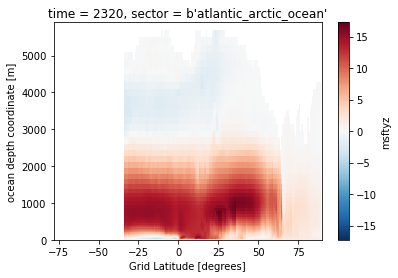

In [14]:
dsAMOC = xr.open_dataset('/Users/6497241/surfdrive/Documents/PlioMIP2-OHT/Data/Raw_data/EC-Earth3-LR/'+experiment+'/amoc_annual_100yr.nc')

#Mask zero values
a = dsAMOC.msftyz/rho_sw/1e12
c = a.where(a!=0)
c[0].plot()

dsM2 = xr.Dataset(data_vars = dict(AMOC=(("time","z","lat"), c.values)), coords = dict(time = dsAMOC.time.values, z = dsAMOC.lev.values, lat = dsAMOC.rlat.values))
xr.Dataset.to_netcdf(dsM2, path = datafolder+'Processed/'+model+'/'+experiment+'/AMOC_annual_100yr.nc')

## Annual SST timeseries (100 years)

In [15]:
dstos = xr.open_dataset(folder+experiment+'/EC-Earth3.3_'+experiment+'.SST.timeseries_no_ann_cycle.nc', decode_times=False)
dsclim = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)

tos = dstos.sst
tosann = np.zeros([100,180,360])

for i in range(0,100):
    tosann[i] = tos[0+i*12:12+i*12].mean(dim='time')

if experiment == 'E280':
    year1 = 2320
    year2 = 2419
else:
    year1 = 3310
    year2 = 3409

dsSST1 = xr.Dataset(data_vars = dict(sst=(("time","latitude","longitude"), tosann)), coords = dict(time = np.arange(year1, year2+1), latitude = tos.latitude.values, longitude = tos.longitude.values))

tosann = dsSST1.sst+dsclim.sst.mean(dim='month')

dsSST = xr.Dataset(data_vars = dict(sst=(("time","lat","lon"), tosann)), coords = dict(time = np.arange(year1, year2+1), lat = tos.latitude.values, lon = tos.longitude.values))
xr.Dataset.to_netcdf(dsSST, path = datafolder+'Processed/'+model+'/'+experiment+'/SST_annual_100yr.nc')

## 100-yr mean SSS (regridded)

In [16]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

sss = regridder(dsS.so[0])

dsSSS = xr.Dataset(data_vars = dict(sss=(("lat","lon"), sss)), coords = dict(lat = sss.latitude.values, lon = sss.longitude.values))
xr.Dataset.to_netcdf(dsSSS, path = datafolder+'Processed/'+model+'/'+experiment+'/SSS_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean sea-ice (regridded)

In [17]:
dsi = dsice.drop('time')

djf = (dsi.siconc[11:1200:12]+dsi.siconc[0:1200:12]+dsi.siconc[1:1200:12])/3
djf = djf.mean(dim='time')

mam = (dsi.siconc[2:1200:12]+dsi.siconc[3:1200:12]+dsi.siconc[4:1200:12])/3
mam = mam.mean(dim='time')

jja = (dsi.siconc[5:1200:12]+dsi.siconc[6:1200:12]+dsi.siconc[7:1200:12])/3
jja = jja.mean(dim='time')

son = (dsi.siconc[8:1200:12]+dsi.siconc[9:1200:12]+dsi.siconc[10:1200:12])/3
son = son.mean(dim='time')

dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsi, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

si_djf = regridder(djf)
si_mam = regridder(mam)
si_jja = regridder(jja)
si_son = regridder(son)

si = (si_djf+si_mam+si_jja+si_son)/4

dsSI = xr.Dataset(data_vars = dict(si_djf=(("lat","lon"), si_djf), si_mam = (("lat","lon"), si_mam), si_jja = (("lat","lon"), si_jja), si_son = (("lat","lon"), si_son), si_mean = (("lat","lon"), si)), coords = dict(lat = si_djf.latitude.values, lon = si_djf.longitude.values))
xr.Dataset.to_netcdf(dsSI, path = datafolder+'Processed/'+model+'/'+experiment+'/SI_100yr.nc')
dsSI

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    si_djf   (lat, lon) float64 nan nan nan nan nan ... 97.91 97.91 97.91 97.91
    si_mam   (lat, lon) float64 nan nan nan nan nan ... 97.48 97.48 97.48 97.48
    si_jja   (lat, lon) float64 nan nan nan nan nan ... 93.73 93.72 93.72 93.72
    si_son   (lat, lon) float64 nan nan nan nan nan ... 98.47 98.47 98.47 98.47
    si_mean  (lat, lon) float64 nan nan nan nan nan ... 96.9 96.9 96.89 96.89

## 100-yr mean top 100 m salinity

In [18]:
def makedz(z):
    dz = np.zeros(len(z))
    dz[0] = z[0].values*2
    depth = dz[0]
    for i in range(1,len(z)):
        dz[i] = (z[i]-depth)*2
        depth = depth+dz[i] #Depth spacing. Units: cm
    return xr.DataArray(data=dz, dims=("lev"))

regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)
weights = makedz(dsS.lev[0:24])

s100m = regridder(dsS.so[0:24].weighted(weights).mean(dim='lev'))

dsS100m = xr.Dataset(data_vars = dict(s100m=(("lat","lon"), s100m)), coords = dict(lat = s100m.latitude.values, lon = s100m.longitude.values))
xr.Dataset.to_netcdf(dsS100m, path = datafolder+'Processed/'+model+'/'+experiment+'/so100m_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr zonal mean salinity

In [19]:
salt_atl = dsS.so

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsS, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

salt = regridder(salt_atl)
mask = regularAtlmask(salt)

salt_zm = salt.where(mask>-1).mean(dim='longitude')

dszm = xr.Dataset(data_vars = dict(so=(("z","lat"), salt_zm)), coords = dict(z = salt_zm.lev.values, lat = salt_zm.latitude.values))
xr.Dataset.to_netcdf(dszm, path = datafolder+'Processed/'+model+'/'+experiment+'/so_zm_100yr.nc')

## 100-yr zonal mean temperature

In [20]:
temp_atl = dsT.thetao

#Regrid to 1x1 rectangular grid
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsT, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

temp = regridder(temp_atl)
mask = regularAtlmask(temp)

temp_zm = temp.where(mask>-1).mean(dim='longitude')

dtzm = xr.Dataset(data_vars = dict(thetao=(("z","lat"), temp_zm)), coords = dict(z = temp_zm.lev.values, lat = temp_zm.latitude.values))
xr.Dataset.to_netcdf(dtzm, path = datafolder+'Processed/'+model+'/'+experiment+'/thetao_zm_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


## 100-yr mean wind at 1000 hPa

In [25]:
if experiment == 'E280':
    dsu = xr.open_dataset(folder+'/E280/Atm/EC-Earth3.3_PI_uv.nc')
else:
    dsu = xr.open_dataset(folder+'/Eoi400/Atm/EC-Earth3.3_mPlio_uv.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xarray/coding/times.py:526: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [26]:
ua = dsu.u.mean(dim='time')[0]
va = dsu.v.mean(dim='time')[0]

In [28]:
dsgrid = xr.open_dataset(folder+experiment+'/'+experiment+'.SST.mean_month.nc', decode_times=False)
regridder = xe.Regridder(dsu, dsgrid, 'bilinear', periodic = True, ignore_degenerate=True)

u = regridder(ua)
v = regridder(va)

dsUV = xr.Dataset(data_vars = dict(ua=(("lat","lon"), u), va=(("lat","lon"), v)), coords = dict(lat = u.latitude.values, lon = v.longitude.values))
xr.Dataset.to_netcdf(dsUV, path = datafolder+'Processed/'+model+'/'+experiment+'/UVa_100yr.nc')

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
